In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import mailbox

from tqdm import tqdm
import dateparser

# Load and prettify data

In [2]:
mbox = mailbox.mbox('Takeout/Mail/data.mbox')

In [3]:
columns = ['From', 'Date', 'Reply-to', 'Subject', 'X-Gmail-Labels']
df = pd.DataFrame(columns=columns)

for element in tqdm(mbox, desc='Reading mbox file'):
    df = df.append({ column: element[column] for column in columns }, ignore_index=True)


df = df.dropna().reset_index(drop=True)

# Covert strange string timestamp representation to the datetime
df['Date'] = pd.to_datetime(df['Date'].apply(lambda x: ' '.join(x.split()[:-2])))

# Sort mails by sending date
df = df.sort_values(by=['Date'])

# Use Date field as an index
df.index = df.Date
df = df.drop('Date', 1)

# Convert labels to list
df['X-Gmail-Labels'] = df['X-Gmail-Labels'].apply(lambda x: x.split(','))

df

Reading mbox file: 100%|██████████| 7386/7386 [00:52<00:00, 140.55it/s]


,From,Reply-to,Subject,X-Gmail-Labels
Date,,,,
2017-05-24 00:00:00,"""Wix.com"" <wix-team@emails.wix.com>","""Wix.com"" <team@emails.wix.com>",TODAY ONLY! Get 50% OFF in the May Madness Sale,"[Trash, Opened, Category Promotions]"
2017-05-24 03:43:47,CyberGhost VPN <postmaster@cyberghost.info>,postmaster@cyberghost.info,Take online privacy to the next level,"[Trash, Opened, Category Promotions]"
2017-05-24 11:00:25,Loggly <welcometeam@loggly.com>,welcometeam@loggly.com,How Bemobi monitors user experience with Loggly,"[Trash, Opened, Category Updates]"
2017-05-24 13:06:34,GitKraken <gitkraken@axosoft.com>,gitkraken@axosoft.com,GitKraken v2.6 Unleashed,"[Trash, Opened, Category Promotions]"
2017-05-25 00:00:00,=?UTF-8?B?0JPRg9GC0LXQvdCx0LXRgNCz?= <gutenpri...,=?UTF-8?B?0JPRg9GC0LXQvdCx0LXRgNCz?= <gutenpri...,=?UTF-8?B?0LzQsNC60LXRgiDQvdCwINGB0L7Qs9C70LDR...,"[Archived, Opened, Category Personal]"
...,...,...,...,...
2020-03-19 00:00:00,"""dependabot[bot]"" <notifications@github.com>",pavlovdog/grafana-prometheus-node-js-example <...,[pavlovdog/grafana-prometheus-node-js-example]...,"[Trash, Opened, Category Forums]"
2020-03-19 00:00:00,"""5bucks.ru"" <noreply@5bucks.ru>",support@5bucks.ru,=?UTF-8?B?0JfQtNGA0LDQstGB0YLQstGD0LnRgtC1LCDQ...,"[Trash, Opened, Category Updates]"
2020-03-19 00:00:00,"""Aviasales"" <news@e.aviasales.ru>",news@e.aviasales.ru,=?UTF-8?Q?=D0=9A=D0=BE=D0=B3=D0=B4=D0=B0_=D1=8...,"[Trash, Opened, Category Promotions]"


# Label frequency

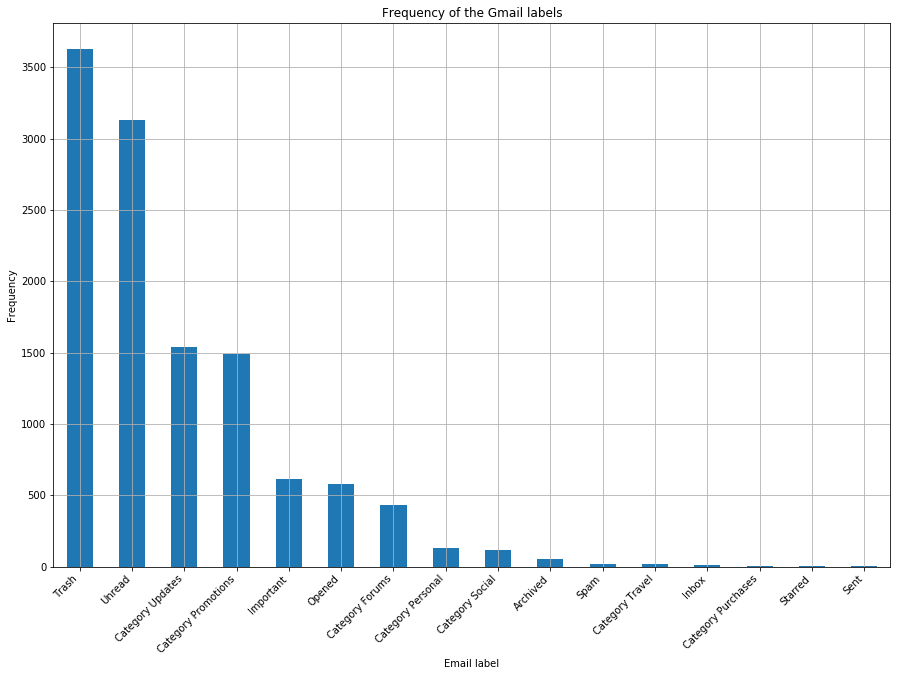

In [4]:
from pandas.core.common import flatten
from collections import Counter

pd.Series(flatten(df['X-Gmail-Labels'].reset_index(drop=True))).value_counts().plot(kind='bar', grid=True, figsize=(15, 10))

plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium',
)

plt.title('Frequency of the Gmail labels')

plt.ylabel('Frequency')
plt.xlabel('Email label')

plt.show()

# Emails amount per month

In [5]:
df_mails_per_month = df.groupby(by=[df.index.year, df.index.month]).agg({ 'From': 'count' })
df_mails_per_month.index.names = ['year', 'month']
df_mails_per_month = df_mails_per_month.reset_index()
df_mails_per_month['year-month'] = df_mails_per_month['year'].astype(str) + '-' + df_mails_per_month['month'].astype(str)
df_mails_per_month = df_mails_per_month.drop(['year', 'month'], 1)

df_mails_per_month['year-month'] = pd.to_datetime(df_mails_per_month['year-month'])

df_mails_per_month.head()

,From,year-month
0,16,2017-05-01
1,52,2017-06-01
2,29,2017-07-01
3,5,2017-08-01
4,4,2017-09-01


In [16]:
df_mails_per_month[df_mails_per_month['year-month'] > pd.Timestamp('now').floor('D') + pd.offsets.Day(-60)]

,From,year-month
32,177,2020-02-01
33,81,2020-03-01


## Display plot

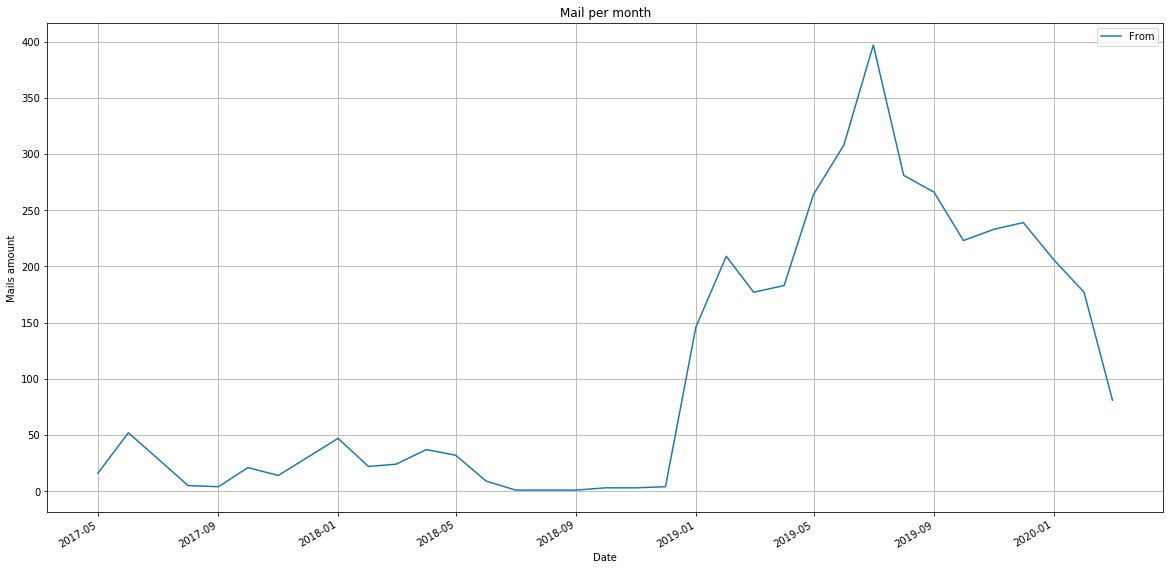

In [6]:
df_mails_per_month.plot(x='year-month', grid=True, figsize=(20, 10))

plt.title('Mail per month')

plt.ylabel('Mails amount')
plt.xlabel('Date')

plt.show()

# Date enrichment

Extract name and email from the `reply-to` and `From` fields.

In [7]:
def extract_name_from(from_value):
    from_name = extract_email_from(from_value)
    
    return from_value.replace(from_name, '').replace('<', '').replace('>', '').strip()

def extract_email_from(from_value):
    if '<' in from_value:
        return from_value.split('<')[1].replace('>', '').strip()
    
    return from_value

df['from-name'] = df['From'].apply(lambda x: extract_name_from(str(x)))
df['from-email'] = df['From'].apply(lambda x: extract_email_from(str(x)))

df[['from-name', 'from-email']]

,from-name,from-email
Date,,
2017-05-24 00:00:00,"""Wix.com""",wix-team@emails.wix.com
2017-05-24 03:43:47,CyberGhost VPN,postmaster@cyberghost.info
2017-05-24 11:00:25,Loggly,welcometeam@loggly.com
2017-05-24 13:06:34,GitKraken,gitkraken@axosoft.com
2017-05-25 00:00:00,=?UTF-8?B?0JPRg9GC0LXQvdCx0LXRgNCz?=,gutenprint@mail.ru
...,...,...
2020-03-19 00:00:00,"""dependabot[bot]""",notifications@github.com
2020-03-19 00:00:00,"""5bucks.ru""",noreply@5bucks.ru
2020-03-19 00:00:00,"""Aviasales""",news@e.aviasales.ru


# 50 most frequent senders according to the `From` field

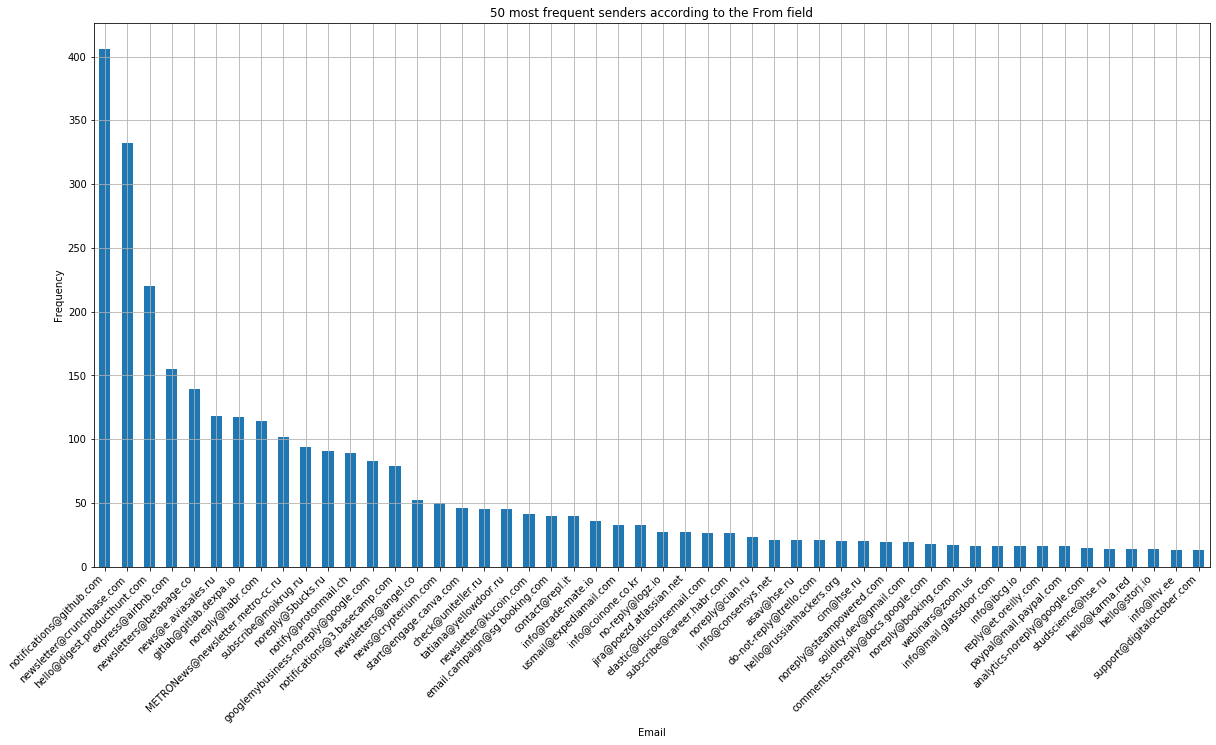

In [8]:
df['from-email'].value_counts()[:50].plot(kind='bar', grid=True, figsize=(20, 10))

plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium',
)

plt.title('50 most frequent senders according to the From field')

plt.ylabel('Frequency')
plt.xlabel('Email')

plt.show()

## Senders activity per each month

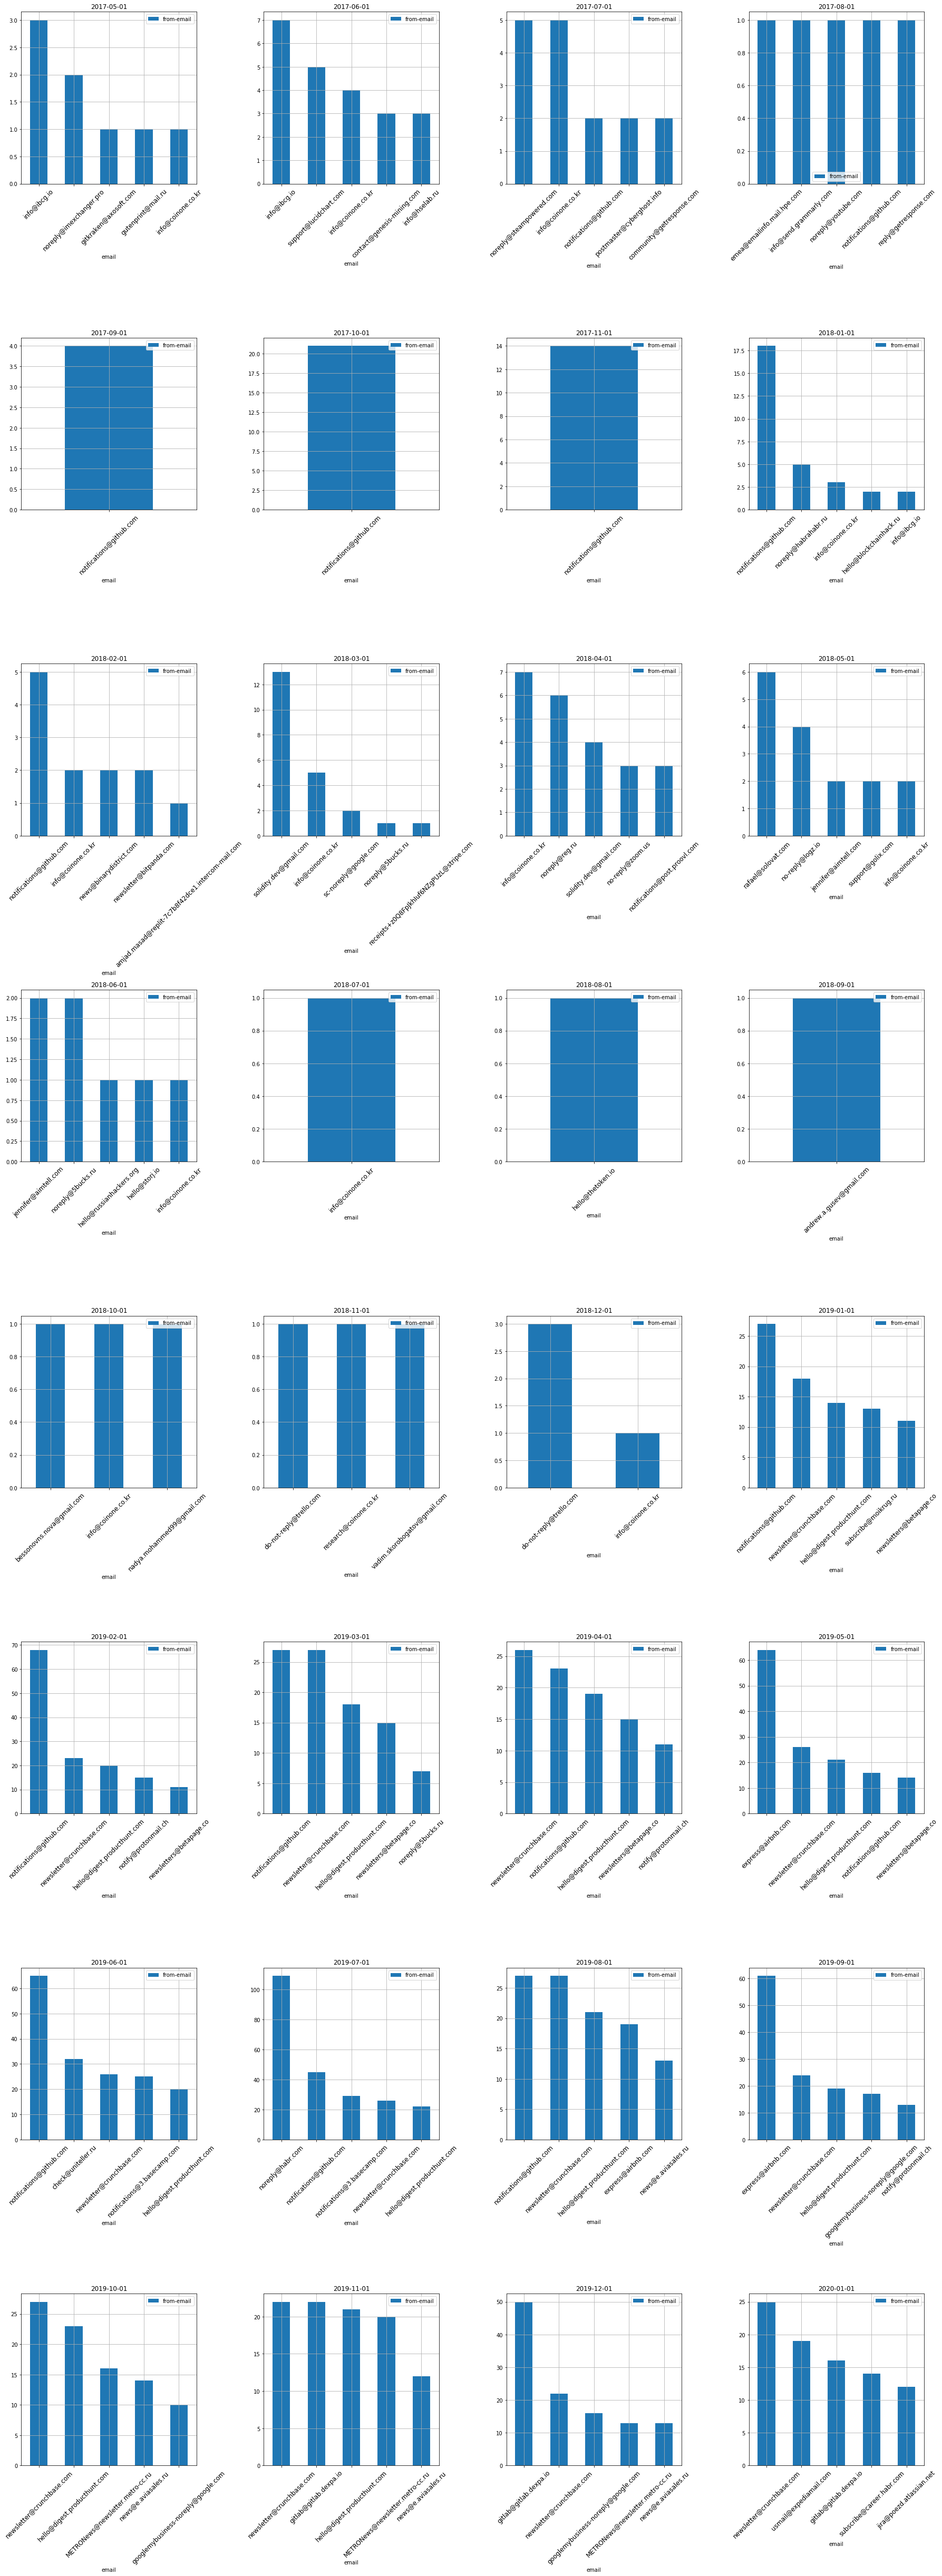

In [9]:
df_sender_per_month = df[['from-email']].groupby(by=[df.index.year, df.index.month, df['from-email']]).count()

# df_sender_per_month

df_sender_per_month.index.names = ['year', 'month', 'email']
df_sender_per_month = df_sender_per_month.reset_index()

df_sender_per_month['year-month'] = df_sender_per_month['year'].astype(str) + '-' + df_sender_per_month['month'].astype(str)
df_sender_per_month = df_sender_per_month.drop(['year', 'month'], 1)

df_sender_per_month['year-month'] = pd.to_datetime(df_sender_per_month['year-month'])

df_sender_per_month.head()

unique_months = df_sender_per_month['year-month'].unique()

# print (len(unique_months))

cols_amount = 4

# Generate axes for each month
fig, axes = plt.subplots(
    len(unique_months) // cols_amount,
    cols_amount, 
    figsize=(25, 2 * len(unique_months))
)

for year_month, ax in zip(unique_months, list(flatten(axes))):
    df_tmp = df_sender_per_month[df_sender_per_month['year-month'] == year_month]\
        .sort_values(by=['from-email'], ascending=False)\
        .reset_index(drop=True)\
        .head()
    
    ax.set_title(np.datetime_as_string(year_month, unit='D'))

    df_tmp.plot(y='from-email', x='email', kind='bar', ax=ax, grid=True)    

    ax.xaxis.set_tick_params(rotation=45, labelsize=12)


plt.tight_layout()
plt.show()